![Group Logo](./MSU_Hollow_Earth_Society_Logo_v2.jpg)

# AST 304 Project 2 Writeup

Elias Taira, Michael Bellaver, Joe Epley , Erin Syerson

In [1]:
import numpy as np
import pandas as pd
from structure import integrate
from eos import density
import matplotlib.pyplot as plt
import scipy.optimize as op

### Defining Physical Constants

For our code, we define all of our physical and astronomical constants in the astro_const.py file. However, since we do not need to use all of the constants contained within the file for this writup, we will only be importing the values that we need.

In [2]:
from astro_const import Msun, Rsun, G

### Implementing the Equation of State

For the equations of state that we will be using to help us in our integration, we store them within the *eos.py* file within the functions *pressure* and *density*, which after taking in either the density or pressure depending on which function is being called, as well as the $\mu_e$ (which we have decided to set to 2 for this assignment), will output the electron degeneracy pressure (in pascals) for pressure and the mass density (in $\frac{kg}{m^3}$) for the density function.

To validate these functions we ran the *test_eos.py* file which takes in an input of our *eos.py* file and validates that it is working properly.

In [3]:
! python ./test_eos.py ./eos.py

Comparing EOS to eos_table.txt...

   rho (table)    rho (test)    difference       P (table)      P (test)    difference

  1.000000e+05  1.000000e+05  5.820766e-16    6.810445e+14  6.810445e+14  0.000000e+00
  1.123655e+05  1.123655e+05  2.590104e-16    8.271108e+14  8.271108e+14  7.556424e-16
  1.262600e+05  1.262600e+05  1.037282e-15    1.004504e+15  1.004504e+15 -7.466368e-16
  1.418727e+05  1.418727e+05  6.154215e-16    1.219944e+15  1.219944e+15  2.049274e-16
  1.594159e+05  1.594159e+05  1.825654e-16    1.481591e+15  1.481591e+15  6.749502e-16
  1.791284e+05  1.791284e+05  6.498986e-16    1.799353e+15  1.799353e+15 -1.389388e-16
  2.012785e+05  2.012785e+05  7.229740e-16    2.185268e+15  2.185268e+15 -3.432074e-16
  2.261676e+05  2.261676e+05  5.147303e-16    2.653950e+15  2.653950e+15  1.883984e-16
  2.541343e+05  2.541343e+05  5.726073e-16    3.223153e+15  3.223153e+15  0.000000e+00
  2.855592e+05  2.855592e+05  8.153497e-16    3.914436e+15  3.914436e+15 -3.831970e-16
  3.208

After running the above cell, we find that our equations of state are working as they should

### Developing the Integration Method

Now onto the step in which we run our integration. For this, we utilized the many functions stored within the *structure.py* file. The first function within the file, *stellar_derivatives*, takes in some mass, pressure, radius and $\mu_e$ and then outputs the derivatives of radius and pressure respectively. This function within the integrate function. Next we have the *central_values* function which essentially just assist in setting up the initial conditions. The *lengthscales* function provides a variable stepsize to ensure that we do not integrate over areas outside of the star. Finally, we have the *integration* function where we actually perform the integration to obtain values for the mass, radius and pressure of the white dwarf as we iterate from the center to the edge of the dwarf.

### Building the Mass-Radius Table

In [4]:
def mass_finder(Pc, wanted_mass, delta_m, eta, xi, mue):
    '''
    Function to be included into our rootfinding method.
    Runs the integrate function, then returns the difference
    between the final mass found by the integration and the
    specified desired mass
    '''
    
    m_step, r_step, p_step = integrate(Pc,delta_m,eta,xi,mue)

    return wanted_mass - m_step[-1]

# setting up array of desired white dwarf masses
mass_array = np.arange(0.1, 1.1, 0.1)

# Setting some initial conditions
mue = 2

eta = 1e-10

xi = 0.05

# initializing arrays to store data
r_array = np.zeros_like(mass_array)

Pc_array = np.zeros_like(mass_array)

Pc_mod_array = np.zeros_like(mass_array)

rho_array = np.zeros_like(mass_array)

rho_mod_array = np.zeros_like(mass_array)

for i in range(len(mass_array)):

    # converting solar mass to units of kg
    Smass = Msun * mass_array[i]
    
    # setting delta_m here as it depends on desired mass
    delta_m = Smass*1e-6
    
    # running the rootfinding method to get ideal central pressure
    desired_pressure = op.bisect(mass_finder, a = 1e19, b = 1e23, xtol = 1e-10, args = (Smass, delta_m, eta, xi, mue))

    m, r, p = integrate(desired_pressure,delta_m,eta,xi,mue)
    
    # assigning data to arrays
    r_array[i] = r[-1]/Rsun

    Pc_array[i] = desired_pressure

    Pc_mod_array[i] = desired_pressure/(G*Smass**2*r[-1]**(-4))

    rho_array[i] = density(desired_pressure, mue)

    rho_mod_array[i] = density(desired_pressure, mue)/(3*Smass/(4*np.pi*r[-1]**3))


For $\xi$, once the value is above 1.75, it starts to iterate over empty space, which begins to return negative pressures, and if $\xi$ is lower than approximately 0.003 it begins to take too many iterations. We found that $\delta m$ is very generous, but it wouldn't make sense to do numbers that are bigger than the mass of one of the white dwarfs because $\delta m$ is meant to be a value smaller than the total mass of a white dwarf, that is a replacement for 0, because setting the central mass to 0 would break the math. When it comes to $\eta$, if it is too large we won't integrate to the pressure at the surface of the star, and if it is too small then it will integrate past the surface of the star and into empty space where we will recieve negative pressures. For central pressure and density, when you increase $\delta m$ central pressure will decrease and density will increase and vice versa.

In [5]:
mr_table = pd.DataFrame()

# pandas explodes when the first column is in latex
# so there is no latex here (as infuriating as it is)
mr_table["M/Msun"] = mass_array

mr_table[r"$R/R_\odot$"] = r_array

mr_table[r"$P_c$"] = Pc_array

mr_table[r"$P_c$ mod"] = Pc_mod_array

mr_table[r"$\rho$"] = rho_array

mr_table[r"$\rho$ mod"] = rho_mod_array

mr_table


,M/Msun,$R/R_\odot$,$P_c$,$P_c$ mod,$\rho$,$\rho$ mod
0,0.1,0.027492,1.517726e+19,0.769594,4.062662e+07,5.987671
1,0.2,0.021820,1.529771e+20,0.769594,1.625065e+08,5.987671
2,0.3,0.019062,5.910135e+20,0.769594,3.656395e+08,5.987671
3,0.4,0.017319,1.541913e+21,0.769594,6.500258e+08,5.987671
4,0.5,0.016077,3.244093e+21,0.769594,1.015665e+09,5.987671
5,0.6,0.015129,5.957043e+21,0.769594,1.462558e+09,5.987671
6,0.7,0.014371,9.958334e+21,0.769594,1.990704e+09,5.987671
7,0.8,0.013746,1.554151e+22,0.769594,2.600103e+09,5.987671
8,0.9,0.013217,2.301450e+22,0.769594,3.290756e+09,5.987671
9,1.0,0.012760,3.269841e+22,0.769594,4.062662e+09,5.987671


### Comparing to Observations

In [6]:
from observations import MassRadiusObservations

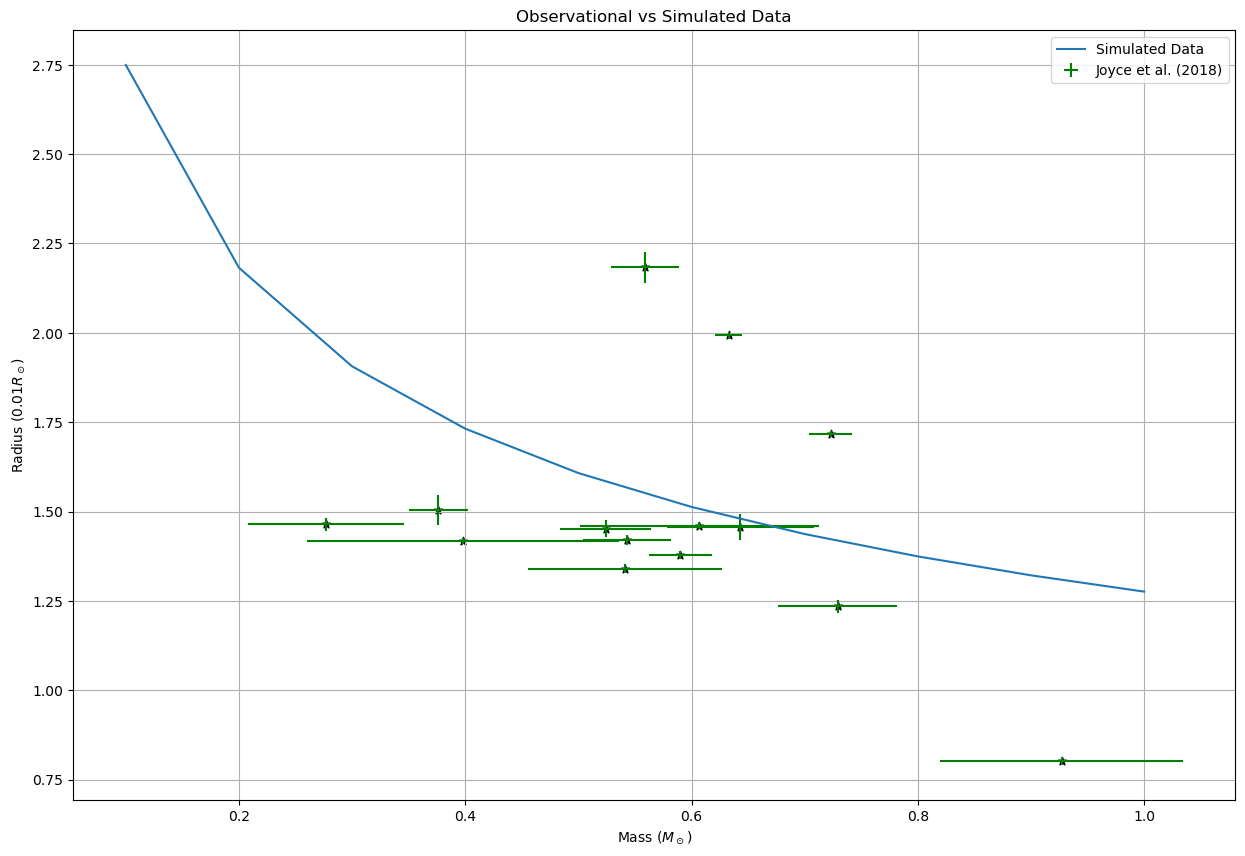

In [7]:
# calling in observational data
obs = MassRadiusObservations()

plt.figure(figsize = ([15,10]))

# plotting simulation data against observational data
plt.errorbar(x = obs.masses, y = obs.radii, xerr = obs.mass_errors, yerr = obs.radius_errors, ls = 'none', label = "Joyce et al. (2018)", color = "green")
plt.scatter(x = obs.masses, y = obs.radii, marker = "*", color = "black")
plt.plot(mr_table["M/Msun"], mr_table[r"$R/R_\odot$"]*100, label = "Simulated Data")
plt.xlabel(r"Mass ($M_\odot$)")
plt.ylabel(r"Radius ($0.01R_\odot$)")
plt.title("Observational vs Simulated Data")
plt.grid()
plt.legend()

While this model is not perfect, it does seem realistic in that it appears to follow the trends set by actual data collected on real life white dwarves. One of the largest aspects of the model that is not realistic is that the starting values for calculations are not zero, as doing so would break the formulas used to calculate the final values. Additionally, this model only works when temperature is “sufficiently low”, giving it properties of an ideal, degenerate, non-relativistic gas. The largest assumption made in this model is that the nucleon-to-electron ratio (mue in the code) is 2.